# Table of Contents
 <p><div class="lev1"><a href="#helper-1">helper</a></div><div class="lev1"><a href="#lmfit-lorentzian-amplitude-2">lmfit lorentzian amplitude</a></div><div class="lev2"><a href="#function-to-fit-using-lmfit-2.1">function to fit using lmfit</a></div><div class="lev2"><a href="#bob-2.2">bob</a></div><div class="lev1"><a href="#loop-over-all-cases-3">loop over all cases</a></div><div class="lev2"><a href="#frequency-fitting-using-lmfit-3.1">frequency fitting using lmfit</a></div><div class="lev1"><a href="#construct-full-model-4">construct full model</a></div><div class="lev1"><a href="#parameter-space-fits-5">parameter space fits</a></div><div class="lev1"><a href="#Mark-1-model-class-6">Mark 1 model class</a></div><div class="lev2"><a href="#extrapolating-6.1">extrapolating</a></div><div class="lev2"><a href="#integrate-psi4-to-get-strain-and-compare-6.2">integrate psi4 to get strain and compare</a></div>

In [451]:
# env source /Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [1]:
import sys
sys.path.append("../../nonspin/")

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [2]:
matplotlib.rcParams.update({'font.size': 18})

# helper

In [3]:

def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [25]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.3f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

# lmfit lorentzian amplitude

In [26]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
)

In [27]:
nrfiles['q1']

'/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5'

In [28]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
# t1=-800
t2=80


In [29]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

In [30]:
for k in psi4s.keys():
    print(1./psi4s[k].fdamp/2/np.pi)

11.706422641558191
11.554740530290251
11.36516841490208
11.32930696199893
11.272552160962043


Text(0.5, 1.0, '$|h|(t)$')

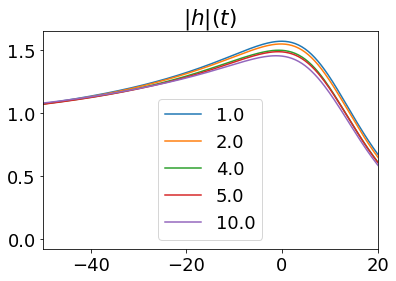

In [31]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
plt.legend()
plt.xlim(-50,20)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

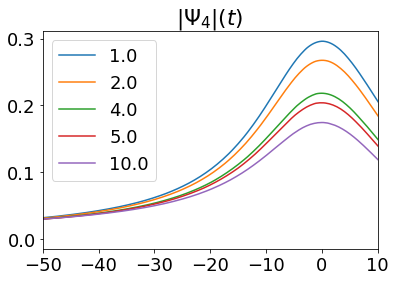

In [32]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
plt.legend()
plt.xlim(-50,10)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

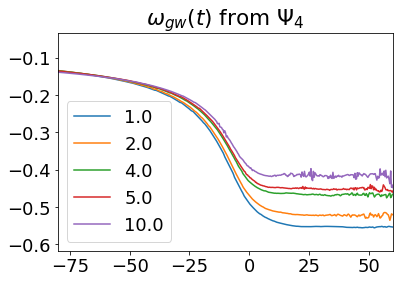

In [33]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

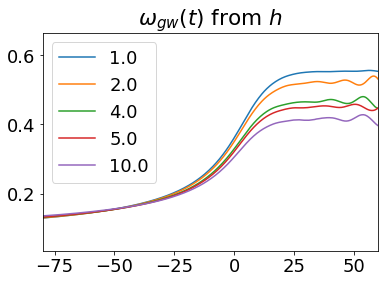

In [34]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

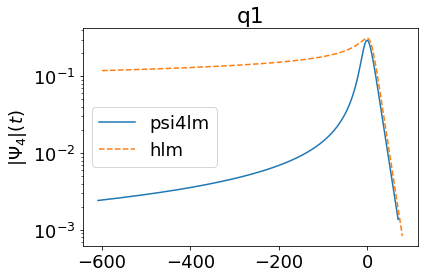

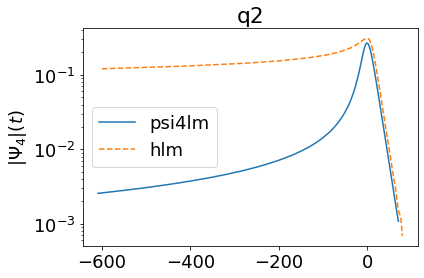

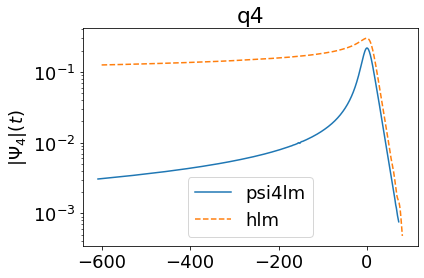

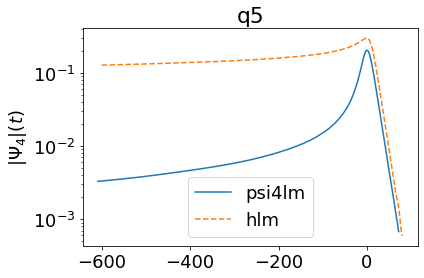

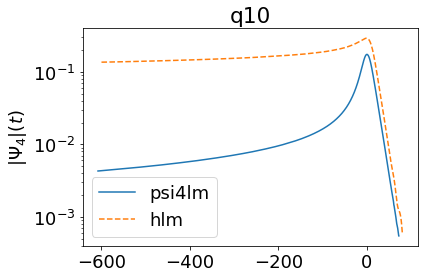

In [35]:
for k in psi4s.keys():
    plt.figure()
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label="psi4lm")
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_amp / psi4s[k].eta / 5, label="hlm", ls='--')
    plt.legend()
#     plt.xlim(-80,60)
    plt.yscale('log')
    plt.title(k)
    plt.ylabel(r'$|\Psi_4|(t)$')
    plt.show()
    plt.close()

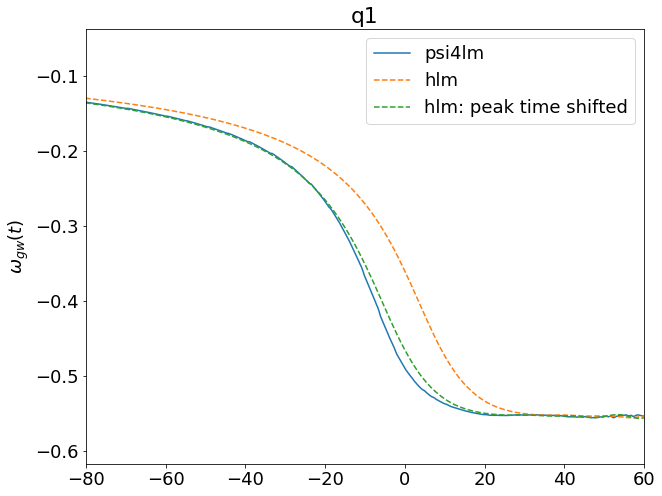

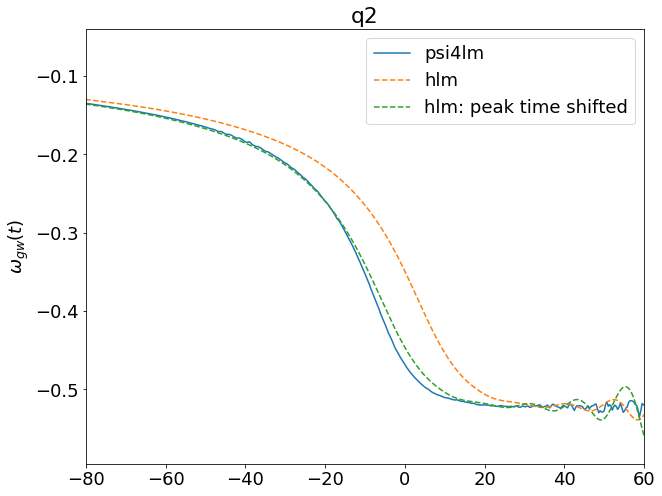

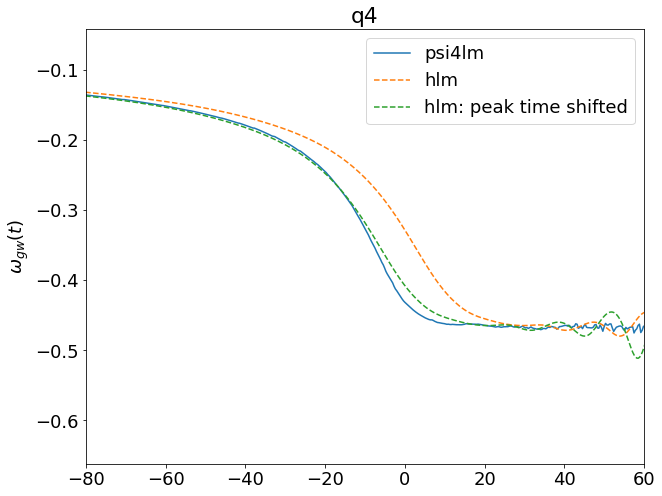

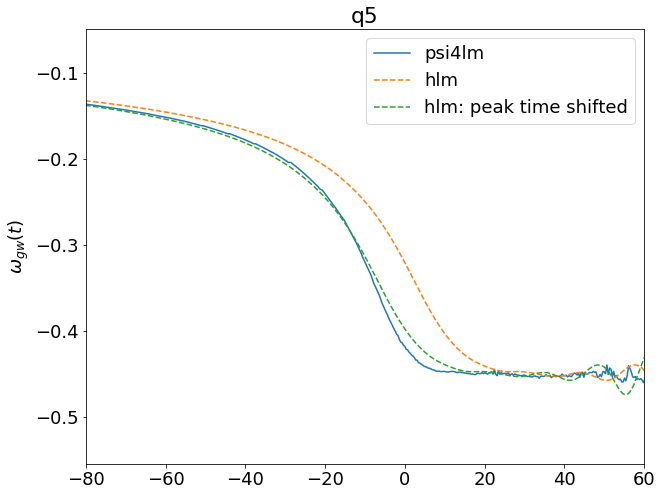

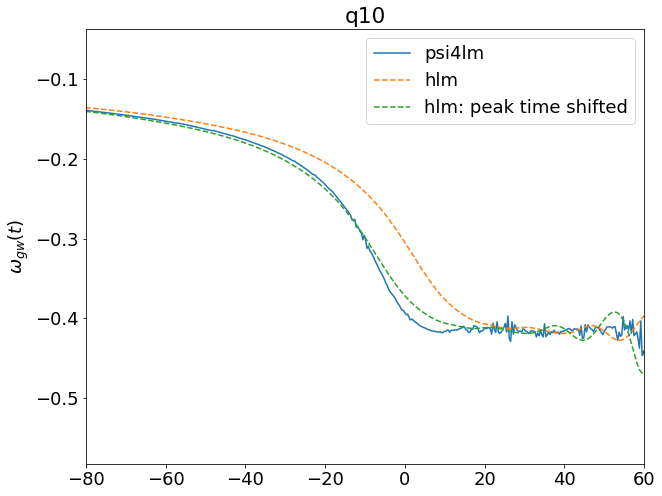

In [49]:
for k in psi4s.keys():
    
    time_shift = psi4s[k].hlm_time_at_max_idx - psi4s[k].time_at_max_idx
    
    plt.figure(figsize=(10,8))
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label="psi4lm")
    plt.plot(psi4s[k].nrdata.times, -psi4s[k].hlm_ang_freq, label="hlm", ls='--')
    plt.plot(psi4s[k].nrdata.times + time_shift, -psi4s[k].hlm_ang_freq, label="hlm: peak time shifted", ls='--')
    plt.legend()
    plt.xlim(-80,60)
    # plt.yscale('log')
    plt.title(k)
    plt.ylabel(r'$\omega_{gw}(t)$')
    plt.show()
    plt.close()

## function to fit using lmfit

In [463]:
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_amp_ramp_up(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        
#         a2 = params['a2']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
#         model +=+ a2 / (t - tp)**4
        
#         a_tdamp = params['a_tdamp']
#         a_tp = params['a_tp']
#         a_ap = params['a_ap']
        
#         sech = 1/np.cosh( (a_tp - t) / a_tdamp )
#         model += a_ap * sech
        
        
        return model
    
    def model_amp_ramp_up_to_min(self, params, t, data):
        model = self.model_amp_ramp_up(params, t)
        return model - data
        
    def fit_amp_ramp_up(self, fix_tdamp, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_amp_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_amp[self.model_amp_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-100, max=200)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=2000)
        params.add('a1', value=0., min=-2000, max=4000)
        
#         params.add('a2', value=100., min=-800000, max=400000)
        
        
#         params.add('a_tdamp', value=20., min=1, max=200)
#         params.add('a_tp', value=0, min=-100, max=200)
#         params.add('a_ap', value=0., min=-2000, max=2000)
        
        fcn2min = self.model_amp_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.amp_ramp_up_result = minner.minimize()

        # calculate final result
        self.amp_ramp_up_final = self.fit_data + self.amp_ramp_up_result.residual

        # write error report
        report_fit(self.amp_ramp_up_result)
        
        
        
    def model_amp_bob(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        ap = params['ap']
        
#         tdamp_vary = params['tdamp_vary']
#         t1 = tdamp/4
#         t2 = t1 + 10
#         t1 = 15
#         t2 = t1 + 20
#         trans = self.planck_taper(t, t1, t2)
        
#         vary_damp =  (1. - trans) * tdamp_vary + trans * tdamp
#         vary_damp = tdamp
        
#         sech = 1/np.cosh( (tp - t) / tdamp )
#         sech = 1/np.cosh( (tp - t) / vary_damp + (params['b']*(tp - t) / vary_damp)**2 )

        sech = 1/np.cosh( (tp - t) / tdamp )
        model = ap * sech

        return model
    
    def model_amp_bob_to_min(self, params, t, data):
        model = self.model_amp_bob(params, t)
        return model - data
        
    def fit_amp_bob(self, fix_tdamp, t1=-20, t2=20):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_bob_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_bob = self.Psi4.times[self.model_amp_bob_mask]
        self.fit_data_bob = self.Psi4.psi4lm_amp[self.model_amp_bob_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=0, min=-100, max=200)
        params.add('ap', value=0., min=-2000, max=2000)
        
#         params.add('tdamp_vary', value=20., min=1, max=200)
#         params.add('b', value=0., min=-2000, max=2000)
        
        
        fcn2min = self.model_amp_bob_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_bob, self.fit_data_bob))
        
        self.amp_bob_result = minner.minimize()

        # calculate final result
        self.amp_bob_final = self.fit_data_bob + self.amp_bob_result.residual

        # write error report
        report_fit(self.amp_bob_result)
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def amp_model(self, times, t0 = -10, sigma=10, params_ramp_up=None, params_bob=None):
        
        if params_ramp_up is None:
            params_ramp_up = self.amp_ramp_up_result.params
        if params_bob is None:
            params_bob = self.amp_bob_result.params
        
        self.ramp_up = self.model_amp_ramp_up(params_ramp_up, times)
        self.bob = self.model_amp_bob(params_bob, times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.bob
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_amp
        self.y_model = self.amp_model(self.t_data, t0=t0, sigma=sigma)

In [464]:
q1_fit = Model(psi4s['q1'])
q1_fit.fit_amp_ramp_up(fix_tdamp=False, t1=-800, t2=-10)
q1_fit.fit_amp_bob(fix_tdamp=False, t1=-10, t2=20)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 1762
    # variables        = 5
    chi-square         = 3.1551e-06
    reduced chi-square = 1.7957e-09
    Akaike info crit   = -35477.9031
    Bayesian info crit = -35450.5321
[[Variables]]
    tdamp:    29.4164072 +/- 4.97954144 (16.93%) (init = 20)
    tp:       23.9557449 +/- 2.78785843 (11.64%) (init = 20)
    lor_amp: -3.43704449 +/- 2.19616547 (63.90%) (init = 0)
    a0:      -0.36976969 +/- 0.00133067 (0.36%) (init = 0)
    a1:       103.971900 +/- 48.1592279 (46.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1)    = -1.000
    C(tp, a1)         =  1.000
    C(tp, lor_amp)    = -1.000
    C(tdamp, lor_amp) =  1.000
    C(tdamp, a1)      = -1.000
    C(tdamp, tp)      = -1.000
    C(tp, a0)         = -0.841
    C(a0, a1)         = -0.837
    C(lor_amp, a0)    =  0.836
    C(tdamp, a0)      =  0.829
[[Fit Statistics]]
    # fitting meth

In [465]:
q1_fit_fix_tdamp = Model(psi4s['q1'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
# q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=60)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1762
    # variables        = 4
    chi-square         = 3.7431e-06
    reduced chi-square = 2.1292e-09
    Akaike info crit   = -35178.7804
    Bayesian info crit = -35156.8835
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.8320541 +/- 0.08211022 (0.26%) (init = 20)
    lor_amp: -81.7729801 +/- 0.76637448 (0.94%) (init = 0)
    a0:      -0.37493638 +/- 8.6571e-04 (0.23%) (init = 0)
    a1:       961.386103 +/- 8.84170844 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.770
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 206
    # variables        = 2
    chi-square         = 1.4428e-04
    reduced chi-square = 7.0725e-07
    

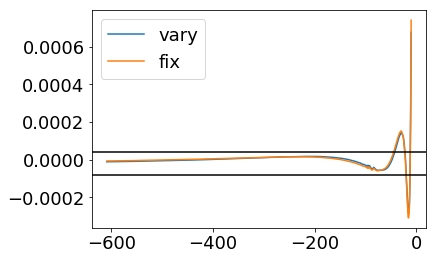

In [466]:

plt.figure()
# plt.plot(q1_fit.fit_times, q1_fit.fit_data)
plt.plot(q1_fit.fit_times, q1_fit.amp_ramp_up_result.residual, label='vary')
plt.plot(q1_fit_fix_tdamp.fit_times, q1_fit_fix_tdamp.amp_ramp_up_result.residual, label='fix')
plt.legend()
plt.axhline(4e-5, c='k')
plt.axhline(-8e-5, c='k')

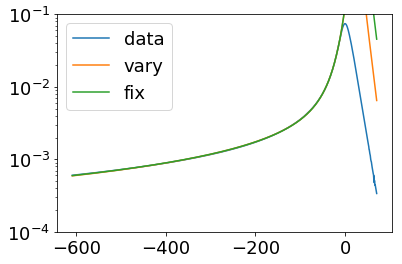

In [467]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


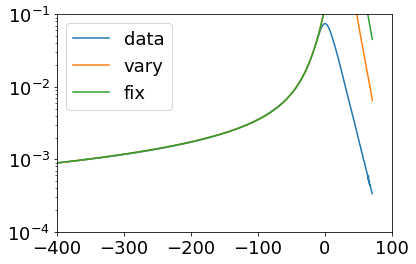

In [468]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.xlim(-400,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


(-10, 10)

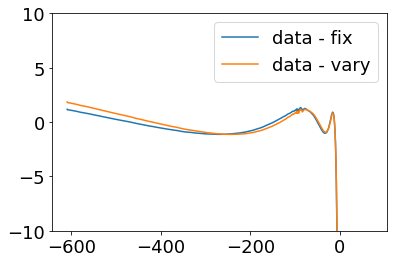

In [469]:
# residuals in extrapolation

ttt = q1_fit.Psi4.times
dddata = q1_fit.Psi4.psi4lm_amp
dddvary = q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times)
dddfix = q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times)

plt.figure()
plt.plot(ttt, 100*(dddata - dddfix)/dddata, label='data - fix')
plt.plot(ttt, 100*(dddata - dddvary)/dddata, label='data - vary')
plt.legend()
# plt.xlim(-600,100)
plt.ylim(-10,10)



## bob

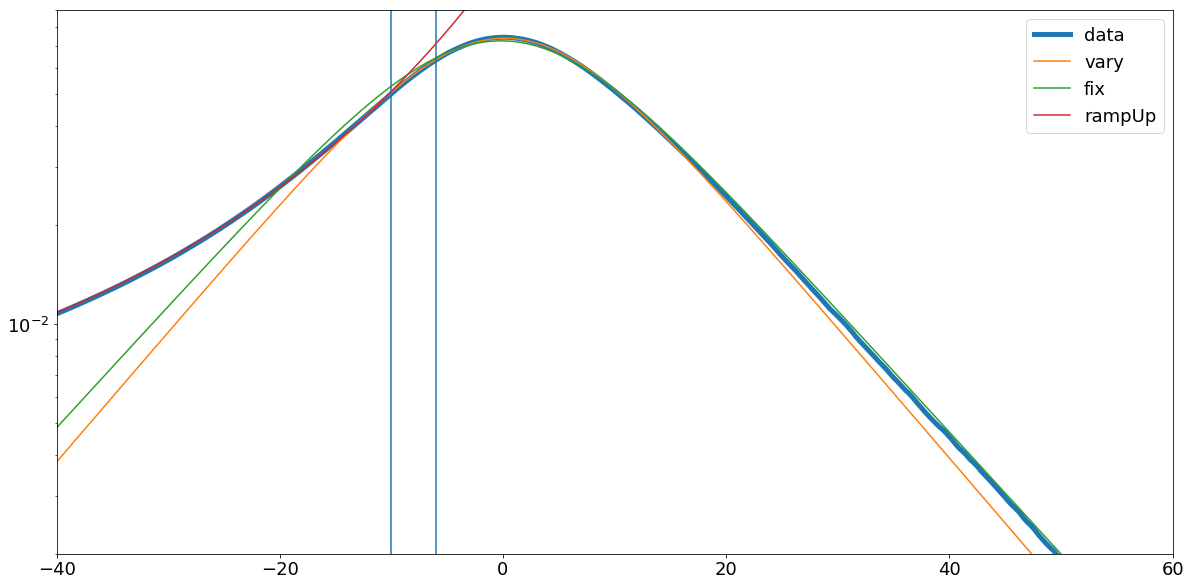

In [470]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data', lw=5)

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_bob(q1_fit.amp_bob_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_bob(q1_fit_fix_tdamp.amp_bob_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='rampUp')

plt.legend()
# plt.xlim(-40, 20)
# plt.ylim(0.004,0.09)

plt.xlim(-40, 60)
plt.ylim(0.002,0.09)
plt.axvline(-6)
plt.axvline(-10)

plt.yscale('log')


In [471]:
test_full_amp = q1_fit_fix_tdamp.amp_model(psi4s['q1'].times, t0=-10, sigma=10)

(-30, 30)

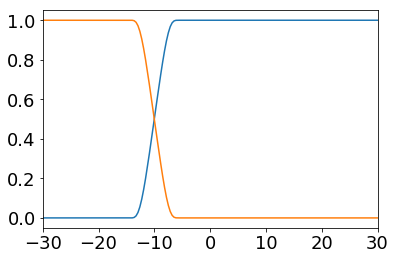

In [472]:
plt.figure()
plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.trans)
plt.plot(psi4s['q1'].times, 1. - q1_fit_fix_tdamp.trans)
plt.xlim(-30,30)

(-60, 70)

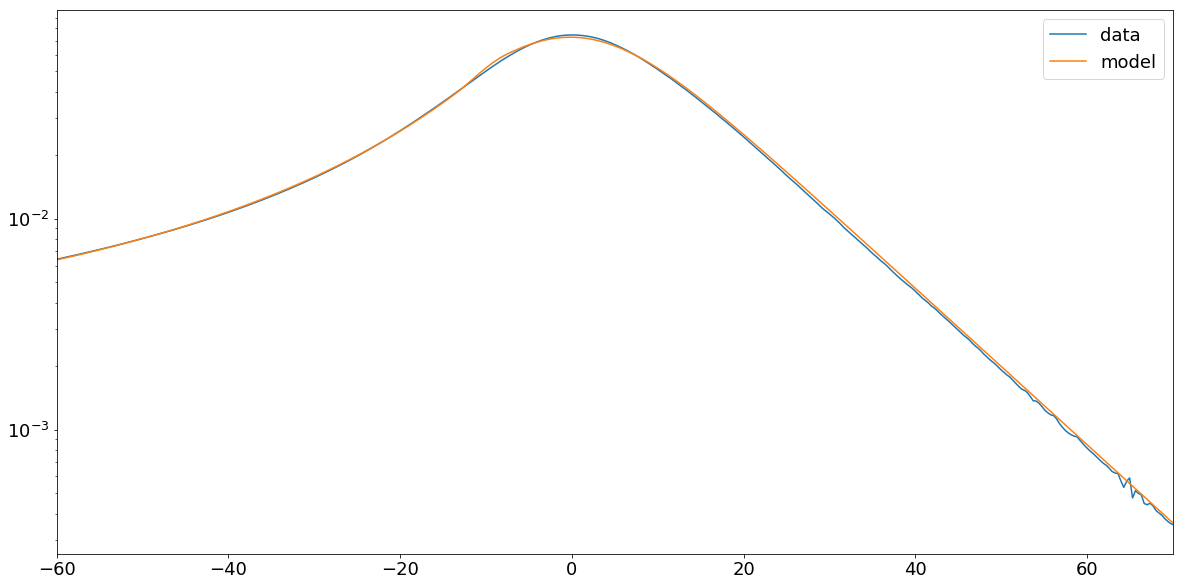

In [473]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.ramp_up, label='rampup')
# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.bob, label='bob')

plt.plot(psi4s['q1'].times, test_full_amp, label='model')

plt.yscale('log')
plt.legend()
plt.xlim(-60,70)
# plt.ylim(0.02,0.08)

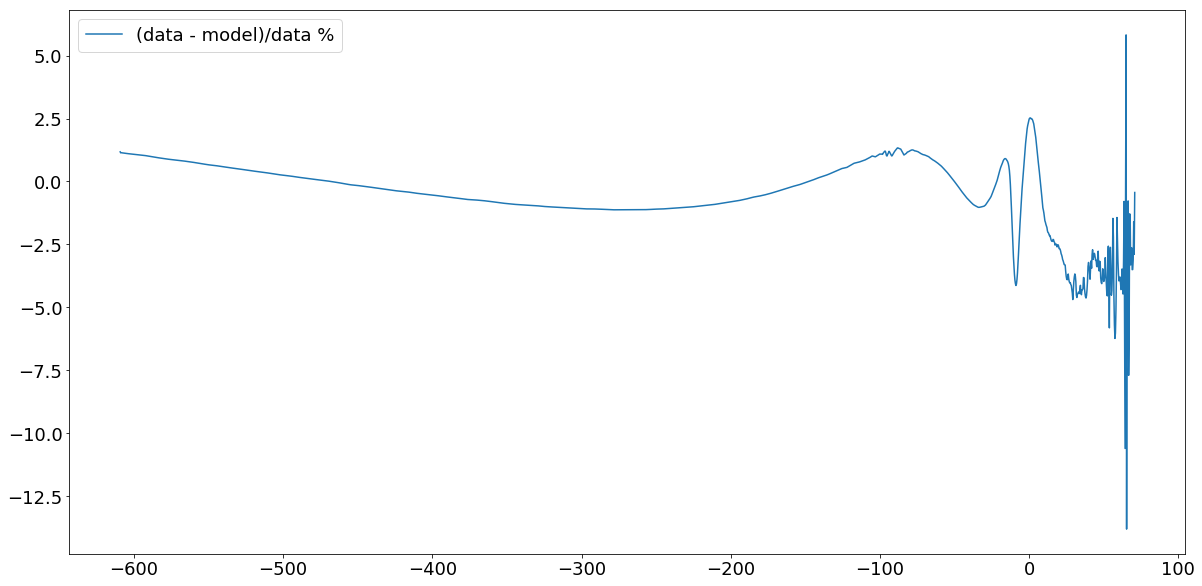

In [474]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, 100*(q1_fit.Psi4.psi4lm_amp - test_full_amp)/q1_fit.Psi4.psi4lm_amp, label='(data - model)/data %')

plt.legend()
# plt.xlim(-40,40)
# plt.ylim(0.02,0.08)

In [475]:
q1_fit_fix_tdamp.compare_model_with_data()

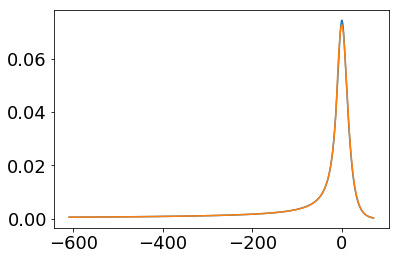

In [476]:
plt.figure()
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_data)
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_model)

# loop over all cases

In [477]:
fit_psi4s = {}
for k in psi4s.keys():
    print('working: {}'.format(k))
    print("\n")
    fit_psi4s.update({k:Model(psi4s[k])})
    print("fitting ramp up")
    fit_psi4s[k].fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
    print("\n")
    print("fitting bob")
    fit_psi4s[k].fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
    print("\n")
    
    fit_psi4s[k].compare_model_with_data()

working: q1


fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1762
    # variables        = 4
    chi-square         = 3.7431e-06
    reduced chi-square = 2.1292e-09
    Akaike info crit   = -35178.7804
    Bayesian info crit = -35156.8835
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.8320541 +/- 0.08211022 (0.26%) (init = 20)
    lor_amp: -81.7729801 +/- 0.76637448 (0.94%) (init = 0)
    a0:      -0.37493638 +/- 8.6571e-04 (0.23%) (init = 0)
    a1:       961.386103 +/- 8.84170844 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.770
    C(tp, a0)      = -0.720


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 1.2928e-

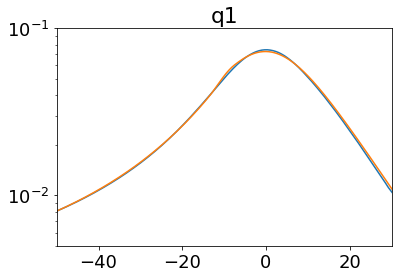

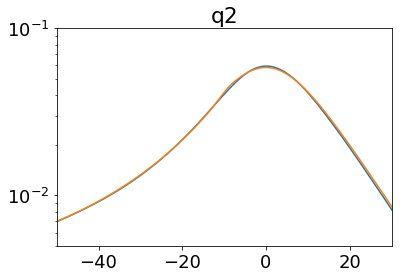

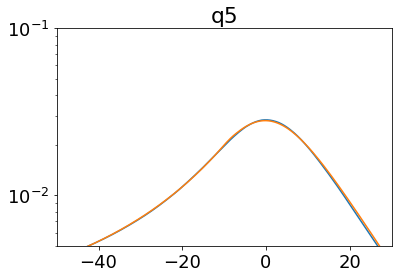

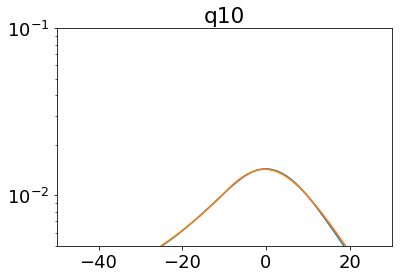

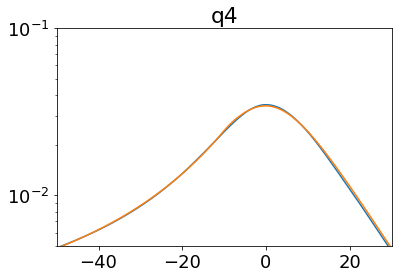

In [478]:
for k in fit_psi4s.keys():
    plt.figure()
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_data)
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_model)
    plt.title(k)
    plt.xlim(-50,30)
    plt.ylim(0.005,0.1)
    plt.yscale('log')
    plt.show()
    plt.close()

## frequency fitting using lmfit

In [479]:
class Model_frequency(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_ramp_up(self, params, t):
        
        t0 = params['t0']
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
        model = (a*b) / ( (t-t0)**2 + a**2 ) + c/(t-t0) + d/(t-t0)**2
        
        return model
    
    def model_freq_ramp_up_to_min(self, params, t, data):
        model = self.model_freq_ramp_up(params, t)
        return model - data
        
    def fit_freq_ramp_up(self, t1=-200, t2=0):
        self.model_freq_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_freq_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=0, min=-30, max=60)
        params.add('a', value=10., min=-2000, max=5000)
        params.add('b', value=0., min=-2000, max=2000)
        params.add('c', value=0., min=-2000, max=2000)
        params.add('d', value=0., min=-10000, max=10000)
        
        fcn2min = self.model_freq_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_ramp_up_result = minner.minimize()

        # calculate final result
        self.freq_ramp_up_final = self.fit_data + self.freq_ramp_up_result.residual

        # write error report
        report_fit(self.freq_ramp_up_result)
        
        
        
    def model_freq_mr(self, params, t):
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']

        dt = t - t0
    #     num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * (num/den)**kappa
        
        return model
    
    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-20, t2=20):
        self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_mr = self.Psi4.times[self.model_freq_mr_mask]
        self.fit_data_mr = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=5., min=-20, max=200)
#         params.add('t0', value=tp_amp, vary=False)
#         params.add('kappa', value=1, min=1e-9, max=10)
        params.add('kappa', value=1, vary=False)
        # params.add('kappa', value=0.25, vary=False) # bob value?
#         params.add('kappa', value=0.36, vary=False) # best fit value?
        # params.add('b', value=1., min=1e-8, max=30)
#         params.add('b', value=10., vary=False)
        # fixing b is ok but fitting is better
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        # params.add('om_f', value=fring * np.pi * 2, min=0.02, max=1)
        params.add('om_f', value=-self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0., min=-200, max=200)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_mr, self.fit_data_mr))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data_mr + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def freq_model(self, times, t0 = -20, sigma=10, params_ramp_up=None, params_mr=None):
        
        if params_ramp_up is None:
            params_ramp_up = self.freq_ramp_up_result.params
        if params_mr is None:
            params_mr = self.freq_mr_result.params
        
        self.ramp_up = self.model_freq_ramp_up(params_ramp_up, times)
        self.mr = self.model_freq_mr(params_mr, times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.mr
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_ang_freq
        self.y_model = self.freq_model(self.t_data, t0=t0, sigma=sigma)

In [480]:
q1_freq_model = Model_frequency(psi4s['q1'])
print("fitting ramp up")
q1_freq_model.fit_freq_ramp_up(t1=-200, t2=-10)
print("\n")
print("fitting mr")
q1_freq_model.fit_freq_mr(t1=-20, t2=40)

fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1923
    # data points      = 558
    # variables        = 5
    chi-square         = 6.1095e-04
    reduced chi-square = 1.1048e-06
    Akaike info crit   = -7648.46507
    Bayesian info crit = -7626.84327
[[Variables]]
    t0:  59.9999998 +/- 7.69294842 (12.82%) (init = 0)
    a:   41.3836360 +/- 10.4973771 (25.37%) (init = 10)
    b:   202.917929 +/- 160.493029 (79.09%) (init = 0)
    c:   33.7101649 +/- 0.50833983 (1.51%) (init = 0)
    d:  -5651.21964 +/- 4465.06319 (79.01%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d)  = -1.000
    C(a, b)  = -1.000
    C(a, d)  =  0.999
    C(t0, d) =  0.999
    C(t0, b) = -0.998
    C(t0, a) =  0.996
    C(t0, c) = -0.977
    C(c, d)  = -0.966
    C(b, c)  =  0.964
    C(a, c)  = -0.957


fitting mr
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 176
    # variable

(-200, 10)

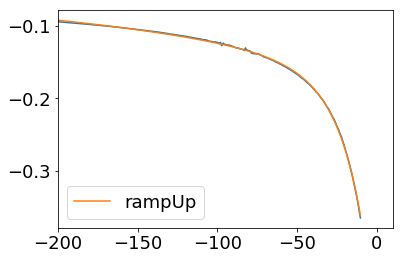

In [481]:

plt.figure()
plt.plot(q1_freq_model.fit_times, q1_freq_model.fit_data)

plt.plot(q1_freq_model.fit_times, q1_freq_model.model_freq_ramp_up(
                                            q1_freq_model.freq_ramp_up_result.params,
                                            q1_freq_model.fit_times
                                            ),
         label='rampUp')

plt.legend()
plt.xlim(-200,10)

In [482]:
fit_psi4s_freq = {}
for k in psi4s.keys():
    print('working: {}'.format(k))
    print("\n")
    fit_psi4s_freq.update({k:Model_frequency(psi4s[k])})
    print("fitting ramp up")
    fit_psi4s_freq[k].fit_freq_ramp_up(t1=-600, t2=-10)
    print("\n")
    print("fitting bob")
    fit_psi4s_freq[k].fit_freq_mr(t1=-20, t2=40)
    print("\n")
    
    fit_psi4s_freq[k].compare_model_with_data()

working: q1


fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 1734
    # variables        = 5
    chi-square         = 0.02095078
    reduced chi-square = 1.2117e-05
    Akaike info crit   = -19625.4097
    Bayesian info crit = -19598.1187
[[Variables]]
    t0:  60.0000000 +/- 0.43739984 (0.73%) (init = 0)
    a:   120.585300 +/- 3.04017528 (2.52%) (init = 10)
    b:   68.5258767 +/- 6.54965415 (9.56%) (init = 0)
    c:   50.3906543 +/- 0.56641814 (1.12%) (init = 0)
    d:  -239.731911 +/- 460.326031 (192.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d)  = -0.999
    C(t0, b) = -0.999
    C(t0, d) =  0.998
    C(a, d)  =  0.962
    C(a, b)  = -0.951
    C(t0, a) =  0.944
    C(t0, c) = -0.943
    C(b, c)  =  0.942
    C(c, d)  = -0.926
    C(a, c)  = -0.800


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 176
 

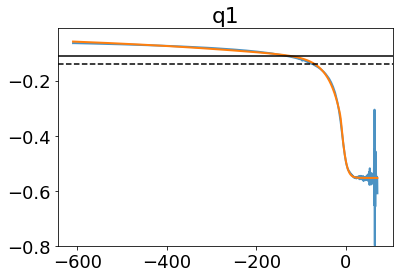

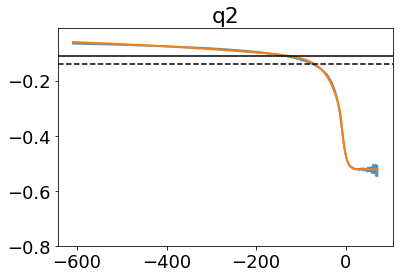

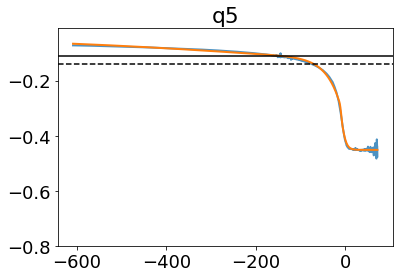

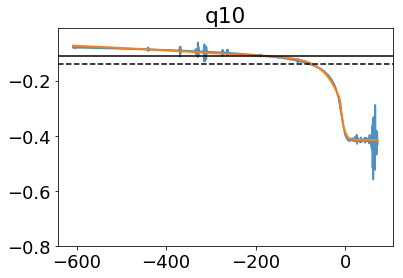

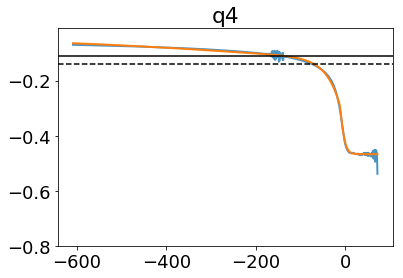

In [483]:
for k in fit_psi4s_freq.keys():
    plt.figure()
    plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_data, lw=2, alpha=0.8)
    
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].ramp_up)
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].mr)
    
    plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_model, lw=2)
    
    plt.title(k)
#     plt.xlim(-60,30)
    plt.ylim(-0.8,-0.01)
#     plt.yscale('log')

    plt.axhline(-0.11, c='k')
    plt.axhline(-0.022 * 2 * np.pi, c='k', ls='--')

    plt.show()
    plt.close()

In [484]:
res=[]
for k in fit_psi4s_freq.keys():
    res.append([psi4s[k].q, fit_psi4s_freq[k].freq_mr_result.params['kappa'].value])
res=np.array(res)

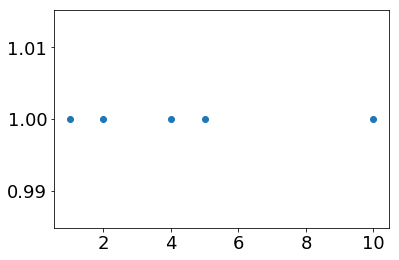

In [485]:
plt.figure()
plt.scatter(res[:,0], res[:,1])

# construct full model

In [486]:
# get amplitude
# get frequency
# get psi4

In [487]:
import scipy.integrate
def compute_integral(times, x):

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)



In [488]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [489]:
class FullModel(object):
    def __init__(self, psi4_object, t1, t2):
        """
        times to evaluate the model at
        """
        
        self.psi4_object = psi4_object
        
        self.mask = (self.psi4_object.times > t1) & (self.psi4_object.times < t2)
        
        self.times = self.psi4_object.times[self.mask]

        self.fit_fix_tdamp = Model(self.psi4_object)
        self.fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
        self.fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
        self.model_full_amp = self.fit_fix_tdamp.amp_model(self.times, t0=-10, sigma=10)
        
        self.freq_model = Model_frequency(self.psi4_object)
        self.freq_model.fit_freq_ramp_up(t1=-600, t2=0)
        self.freq_model.fit_freq_mr(t1=-20, t2=40)
        self.model_full_freq = self.freq_model.freq_model(self.times, t0=-20, sigma=10)
        
        
        self.model_full_phase = compute_integral(self.times, self.model_full_freq)
        
        # average phase difference
        # this only works if times=None and therefore the same as the NR data times
        self.avg_phase_diff = np.mean(self.psi4_object.psi4lm_phase[self.mask] - self.model_full_phase)

        # this only works if times=None and therefore the same as the NR data times
        self.model_full_psi4lm = self.model_full_amp * np.exp(1.j * (self.model_full_phase + self.avg_phase_diff))

        # this only works if times=None and therefore the same as the NR data times
        self.match_array = match(self.model_full_psi4lm, self.psi4_object.psi4lm[self.mask], self.times)
        self.match = np.max(np.abs(self.match_array))
        
        
        

In [490]:
q1_full_model = FullModel(psi4s['q1'], t1=-400, t2=60)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1762
    # variables        = 4
    chi-square         = 3.7431e-06
    reduced chi-square = 2.1292e-09
    Akaike info crit   = -35178.7804
    Bayesian info crit = -35156.8835
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.8320541 +/- 0.08211022 (0.26%) (init = 20)
    lor_amp: -81.7729801 +/- 0.76637448 (0.94%) (init = 0)
    a0:      -0.37493638 +/- 8.6571e-04 (0.23%) (init = 0)
    a1:       961.386103 +/- 8.84170844 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.770
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 1.2928e-04
    reduced chi-square = 1.5032e-06
    A

In [491]:
q1_full_model.match

0.9996702023633973

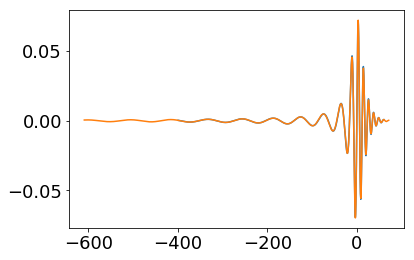

In [492]:
plt.figure()
plt.plot(q1_full_model.times, q1_full_model.model_full_psi4lm.real)
plt.plot(q1_full_model.psi4_object.times, q1_full_model.psi4_object.psi4lm.real)

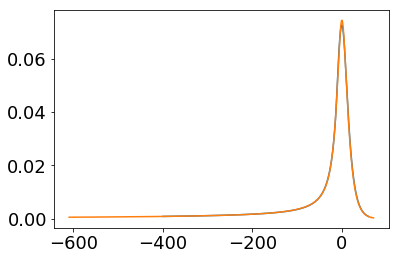

In [493]:
plt.figure()
plt.plot(q1_full_model.times, np.abs(q1_full_model.model_full_psi4lm))
plt.plot(q1_full_model.psi4_object.times, q1_full_model.psi4_object.psi4lm_amp)

(0.01, 0.1)

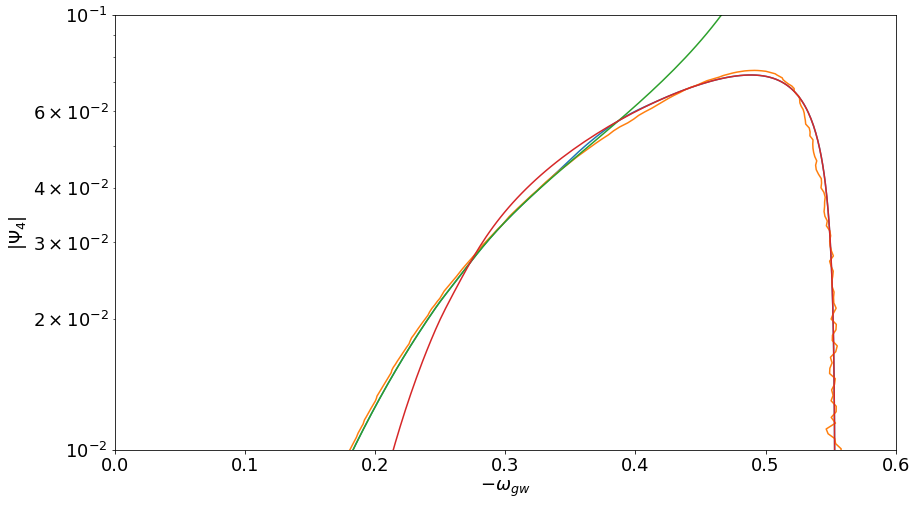

In [494]:
plt.figure(figsize=(14,8))
plt.plot(-q1_full_model.model_full_freq, np.abs(q1_full_model.model_full_psi4lm))
plt.plot(-q1_full_model.psi4_object.psi4lm_ang_freq, q1_full_model.psi4_object.psi4lm_amp)


plt.plot(-q1_full_model.model_full_freq, q1_full_model.fit_fix_tdamp.ramp_up, label='ramp-up model')
plt.plot(-q1_full_model.model_full_freq, q1_full_model.fit_fix_tdamp.bob, label='bob model')


plt.yscale('log')
plt.xlabel(r'$-\omega_{gw}$')
plt.ylabel(r'$|\Psi_4|$')
plt.xlim(0,0.6)
plt.ylim(1e-2,0.1)

In [495]:
full_model = {}
for k in psi4s.keys():
    full_model.update({k:FullModel(psi4s[k], t1=-400, t2=60)})

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1762
    # variables        = 4
    chi-square         = 3.7431e-06
    reduced chi-square = 2.1292e-09
    Akaike info crit   = -35178.7804
    Bayesian info crit = -35156.8835
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.8320541 +/- 0.08211022 (0.26%) (init = 20)
    lor_amp: -81.7729801 +/- 0.76637448 (0.94%) (init = 0)
    a0:      -0.37493638 +/- 8.6571e-04 (0.23%) (init = 0)
    a1:       961.386103 +/- 8.84170844 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.770
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 1.2928e-04
    reduced chi-square = 1.5032e-06
    A

In [496]:
for k in full_model.keys():
    print("{}: match = {}".format(k, full_model[k].match))

q1: match = 0.999670202363
q2: match = 0.999766719674
q5: match = 0.999509168093
q10: match = 0.999098422923
q4: match = 0.999554442212


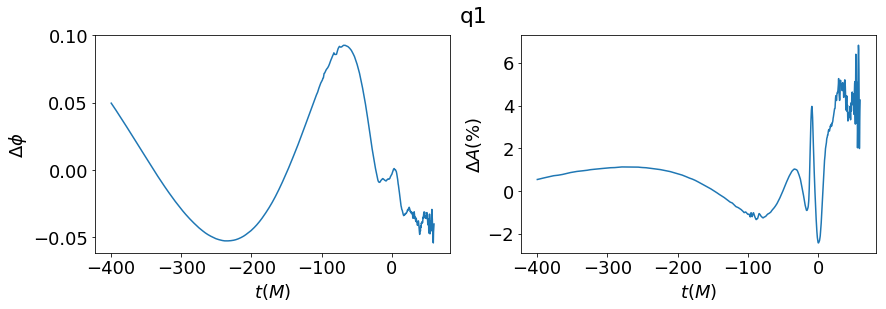

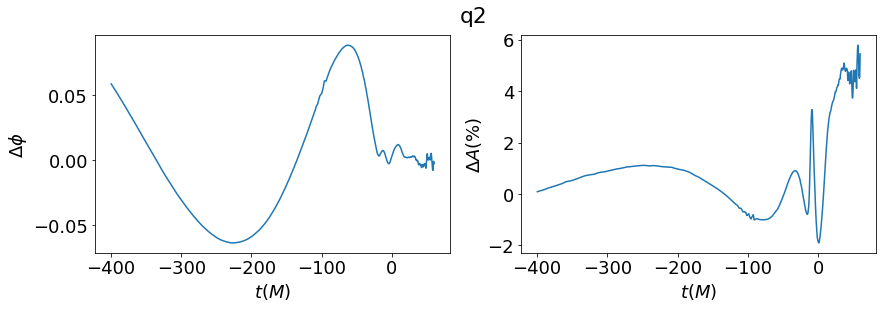

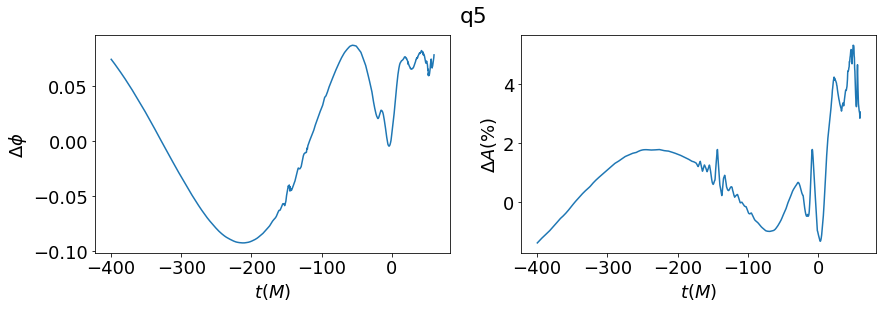

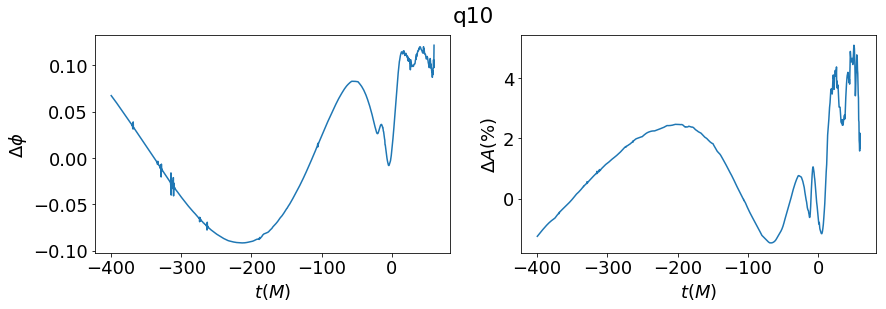

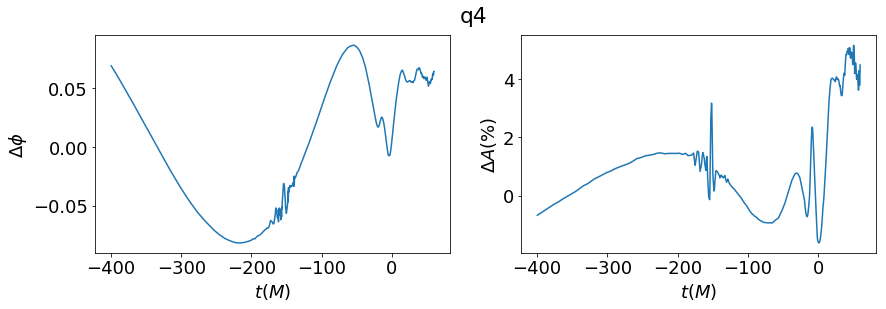

In [497]:
# compute amplitude and phase differences
for k in full_model.keys():
    times = full_model[k].times
    nr_amp = full_model[k].psi4_object.psi4lm_amp[full_model[k].mask]
    nr_phase = full_model[k].psi4_object.psi4lm_phase[full_model[k].mask]
    
    amp_diff = 100. * (full_model[k].model_full_amp - nr_amp) / nr_amp
    
    phase_diff = (full_model[k].model_full_phase + full_model[k].avg_phase_diff) - nr_phase
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].plot(times, phase_diff)
    axes[1].plot(times, amp_diff)
    
    axes[0].set_ylabel(r"$\Delta \phi$")
    axes[1].set_ylabel(r"$\Delta A (\%)$")
    
    axes[0].set_xlabel(r"$t (M)$")
    axes[1].set_xlabel(r"$t (M)$")
    
    fig.suptitle(k)
    
    plt.show()
    plt.close()

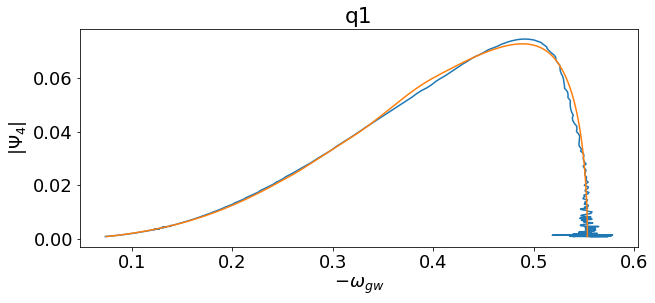

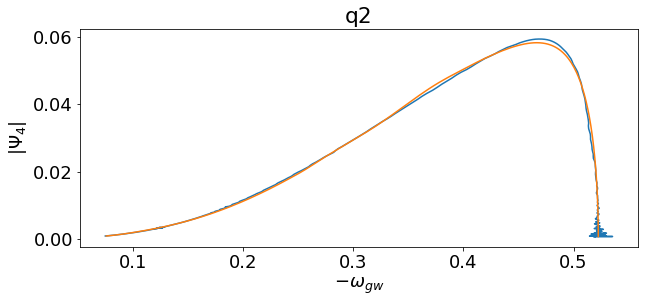

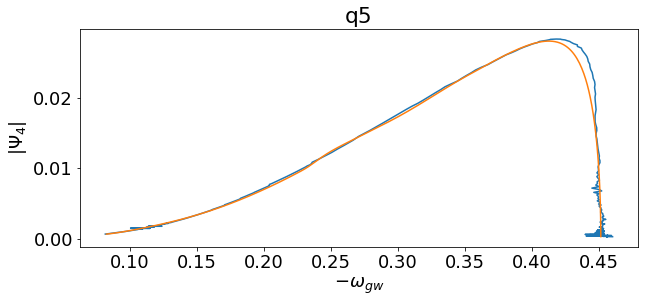

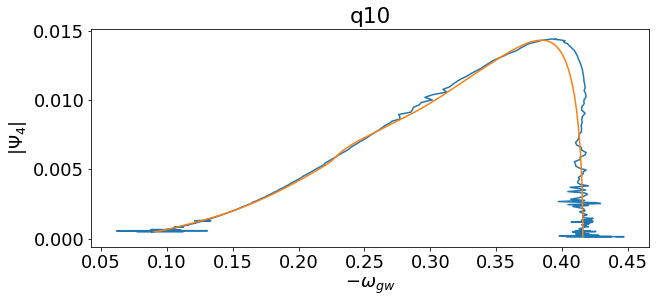

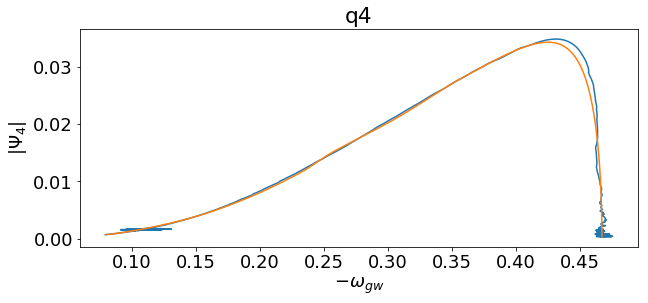

In [498]:
# plot amplitude as a function of frequnecy
for k in full_model.keys():
    times = full_model[k].times
    nr_amp = full_model[k].psi4_object.psi4lm_amp[full_model[k].mask]
    nr_freq = full_model[k].psi4_object.psi4lm_ang_freq[full_model[k].mask]
    
    
    plt.figure(figsize=(10,4))
    plt.plot(-nr_freq, nr_amp)
    plt.plot(-full_model[k].model_full_freq, np.abs(full_model[k].model_full_psi4lm))

    plt.xlabel(r'$-\omega_{gw}$')
    plt.ylabel(r'$|\Psi_4|$')
#     plt.xlim(0,0.6)
    plt.title(k)
    
    
    plt.show()
    plt.close()

In [499]:
q1_fit_fix_tdamp = Model(psi4s['q1'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
test_full_amp = q1_fit_fix_tdamp.amp_model(psi4s['q1'].times, t0=-10, sigma=10)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1762
    # variables        = 4
    chi-square         = 3.7431e-06
    reduced chi-square = 2.1292e-09
    Akaike info crit   = -35178.7804
    Bayesian info crit = -35156.8835
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.8320541 +/- 0.08211022 (0.26%) (init = 20)
    lor_amp: -81.7729801 +/- 0.76637448 (0.94%) (init = 0)
    a0:      -0.37493638 +/- 8.6571e-04 (0.23%) (init = 0)
    a1:       961.386103 +/- 8.84170844 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.770
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 1.2928e-04
    reduced chi-square = 1.5032e-06
    A

In [500]:
q1_freq_model = Model_frequency(psi4s['q1'])
print("fitting ramp up")
q1_freq_model.fit_freq_ramp_up(t1=-600, t2=0)
print("\n")
print("fitting bob")
q1_freq_model.fit_freq_mr(t1=-20, t2=40)
test_full_freq = q1_freq_model.freq_model(psi4s['q1'].times, t0=-20, sigma=10)

fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 1763
    # variables        = 5
    chi-square         = 0.00334536
    reduced chi-square = 1.9029e-06
    Akaike info crit   = -23217.4406
    Bayesian info crit = -23190.0667
[[Variables]]
    t0:  6.03742539 +/- 0.03299067 (0.55%) (init = 0)
    a:   1173.80120 +/- 7.11583727 (0.61%) (init = 10)
    b:  -78.0344892 +/- 0.36016144 (0.46%) (init = 0)
    c:   6.13336833 +/- 0.01361959 (0.22%) (init = 0)
    d:   22.5824981 +/- 0.09874369 (0.44%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  = -0.980
    C(c, d)  =  0.970
    C(t0, c) =  0.868
    C(t0, d) =  0.797
    C(a, c)  =  0.658
    C(a, d)  =  0.622
    C(b, c)  = -0.529
    C(b, d)  = -0.497
    C(t0, a) =  0.476
    C(t0, b) = -0.367


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 176
    # variables   

In [501]:
# self.psi4lm_amp
# self.psi4lm_ang_freq

(-100, 60)

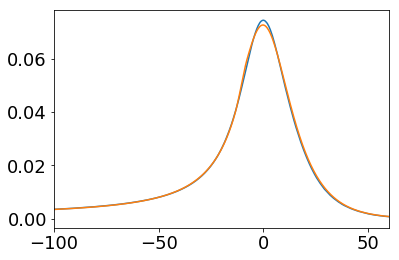

In [502]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_amp)
plt.plot(psi4s['q1'].times, test_full_amp)
plt.xlim(-100,60)

(-50, 60)

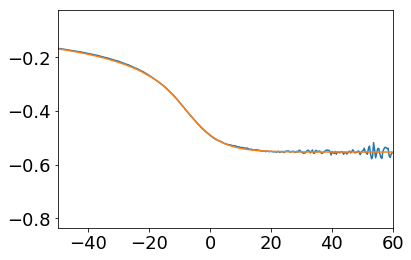

In [503]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_ang_freq)
plt.plot(psi4s['q1'].times, test_full_freq)
plt.xlim(-50,60)

(-100, 60)

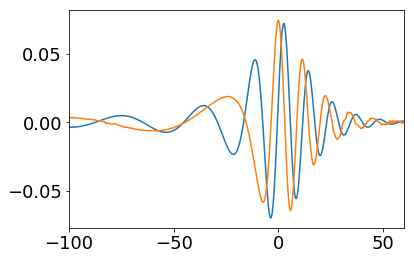

In [504]:
plt.figure()
plt.plot(psi4s['q1'].times, np.real(psi4s['q1'].psi4lm))
plt.plot(psi4s['q1'].times, np.real(psi4s['q1'].psi4lm_amp * np.exp(-1.j * psi4s['q1'].psi4lm_ang_freq * psi4s['q1'].times)))
plt.xlim(-100,60)

(-100, 60)

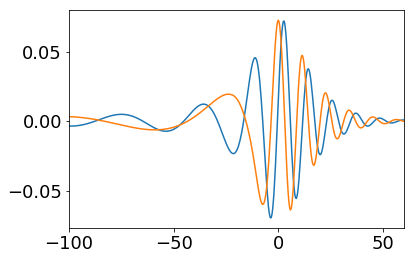

In [505]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm.real)
plt.plot(psi4s['q1'].times, np.real(test_full_amp * np.exp(-1.j * test_full_freq * psi4s['q1'].times)))
plt.xlim(-100,60)

(-600, 60)

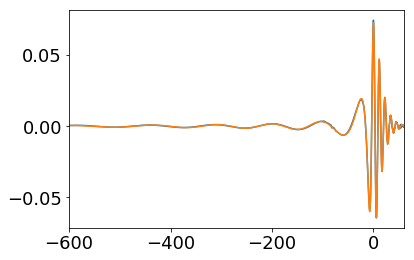

In [506]:
plt.figure()
plt.plot(psi4s['q1'].times, np.real(psi4s['q1'].psi4lm_amp * np.exp(-1.j * psi4s['q1'].psi4lm_ang_freq * psi4s['q1'].times)))
plt.plot(psi4s['q1'].times, np.real(test_full_amp * np.exp(-1.j * test_full_freq * psi4s['q1'].times)))
plt.xlim(-600,60)

In [507]:
model_phase = compute_integral(psi4s['q1'].times, test_full_freq)

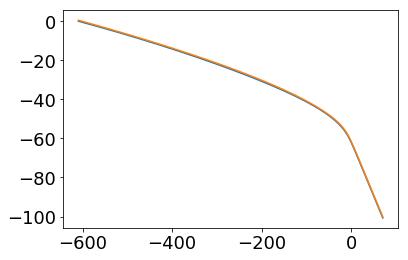

In [508]:
plt.figure()
plt.plot(psi4s['q1'].times, model_phase)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

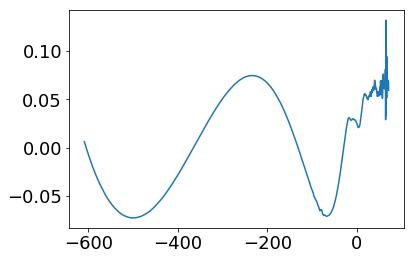

In [509]:
plt.figure()

avg_diff = np.mean(psi4s['q1'].psi4lm_phase - model_phase)

plt.plot(psi4s['q1'].times, (psi4s['q1'].psi4lm_phase - model_phase) - avg_diff)

In [510]:
avg_diff

0.46737959627263265

In [511]:
model_psi4 = test_full_amp * np.exp(1.j * (model_phase+avg_diff))

(-300, 60)

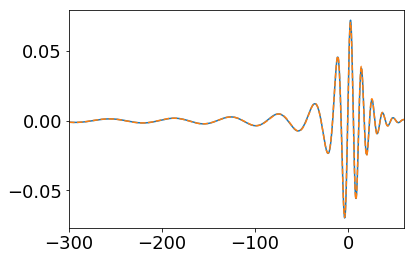

In [512]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm.real)
plt.plot(psi4s['q1'].times, np.real(model_psi4), ls='--')
plt.xlim(-300,60)

In [513]:
t1=np.unwrap(np.angle(model_psi4))
t2=np.unwrap(np.angle(psi4s['q1'].psi4lm))

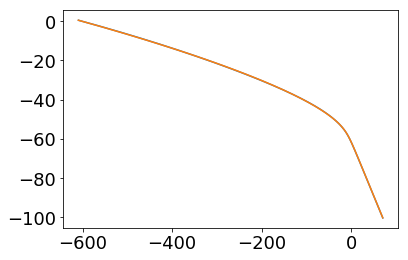

In [514]:
plt.figure()
plt.plot(psi4s['q1'].times, t1)
plt.plot(psi4s['q1'].times, t2)

In [515]:
match_model_nr = match(model_psi4, psi4s['q1'].psi4lm, psi4s['q1'].times)

print("max match = {}".format( np.abs(match_model_nr).max() ))

max match = 0.999667469459


In [516]:
match_nr_nr = match(psi4s['q1'].psi4lm, psi4s['q1'].psi4lm, psi4s['q1'].times)

print("max match = {}".format( np.abs(match_nr_nr).max() ))

max match = 1.0


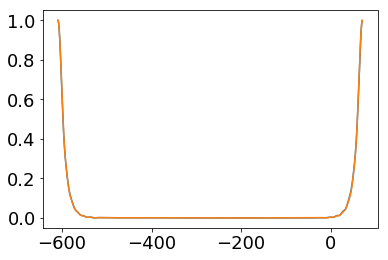

In [517]:
plt.plot(psi4s['q1'].times, np.abs(match_model_nr))
plt.plot(psi4s['q1'].times, np.abs(match_nr_nr))

# parameter space fits

In [518]:
q1 = full_model['q1']

In [519]:
type(q1.fit_fix_tdamp.amp_ramp_up_result)

lmfit.minimizer.MinimizerResult

In [520]:
q1.fit_fix_tdamp.amp_ramp_up_result.params

Parameters([('tdamp',
             <Parameter 'tdamp', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('tp',
             <Parameter 'tp', value=31.832054105728957 +/- 0.0821, bounds=[-100:200]>),
            ('lor_amp',
             <Parameter 'lor_amp', value=-81.77298014126404 +/- 0.766, bounds=[-2000:2000]>),
            ('a0',
             <Parameter 'a0', value=-0.3749363802494372 +/- 0.000866, bounds=[-2000:2000]>),
            ('a1',
             <Parameter 'a1', value=961.3861032222812 +/- 8.84, bounds=[-2000:4000]>)])

In [521]:
q1.fit_fix_tdamp.amp_ramp_up_result.params.keys()

['tdamp', 'tp', 'lor_amp', 'a0', 'a1']

In [522]:
q1.fit_fix_tdamp.amp_ramp_up_result.params['tp']

<Parameter 'tp', value=31.832054105728957 +/- 0.0821, bounds=[-100:200]>

In [523]:
q1.fit_fix_tdamp.amp_ramp_up_result.params['tp'].vary

True

In [524]:
q1.fit_fix_tdamp.amp_bob_result.params

Parameters([('tdamp',
             <Parameter 'tdamp', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('tp',
             <Parameter 'tp', value=-0.1241017879275148 +/- 0.0562, bounds=[-100:200]>),
            ('ap',
             <Parameter 'ap', value=0.0726783726352096 +/- 0.000169, bounds=[-2000:2000]>)])

In [525]:
q1.freq_model.freq_ramp_up_result.params

Parameters([('t0',
             <Parameter 't0', value=6.037425394910343 +/- 0.033, bounds=[-30:60]>),
            ('a',
             <Parameter 'a', value=1173.8012010941384 +/- 7.12, bounds=[-2000:5000]>),
            ('b',
             <Parameter 'b', value=-78.03448917563924 +/- 0.36, bounds=[-2000:2000]>),
            ('c',
             <Parameter 'c', value=6.133368327429707 +/- 0.0136, bounds=[-2000:2000]>),
            ('d',
             <Parameter 'd', value=22.582498107998617 +/- 0.0987, bounds=[-10000:10000]>)])

In [526]:
q1.freq_model.freq_mr_result.params

Parameters([('t0',
             <Parameter 't0', value=-8.159488690754973 +/- 0.0592, bounds=[-20:200]>),
            ('kappa', <Parameter 'kappa', value=1 (fixed), bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('om_f',
             <Parameter 'om_f', value=-0.5534661793193033 (fixed), bounds=[-inf:inf]>),
            ('offset',
             <Parameter 'offset', value=-0.23296479807100923 +/- 0.00116, bounds=[-200:200]>)])

In [527]:
class ParSpaceFits(object):
    def __init__(self, name, full_model_dict):
        self.name = name
        self.full_model_dict = full_model_dict
        
        self.results = {}
        
        for k in self.full_model_dict.keys():
            
            q = self.full_model_dict[k].psi4_object.nrdata.q
            eta = self.full_model_dict[k].psi4_object.nrdata.eta
            self.results.update({k:{"fixed":{}, "vary":{}, 'q':q, 'eta':eta}})
            if self.name == "amp_ramp_up_result":
                for pk in self.full_model_dict[k].fit_fix_tdamp.amp_ramp_up_result.params.keys():
                    entry = self.full_model_dict[k].fit_fix_tdamp.amp_ramp_up_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "amp_bob_result":
                for pk in self.full_model_dict[k].fit_fix_tdamp.amp_bob_result.params.keys():
                    entry = self.full_model_dict[k].fit_fix_tdamp.amp_bob_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "freq_ramp_up_result":
                for pk in self.full_model_dict[k].freq_model.freq_ramp_up_result.params.keys():
                    entry = self.full_model_dict[k].freq_model.freq_ramp_up_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "freq_mr_result":
                for pk in self.full_model_dict[k].freq_model.freq_mr_result.params.keys():
                    entry = self.full_model_dict[k].freq_model.freq_mr_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})

                        
        k = self.full_model_dict.keys()[0]
        self.vary_parnames = self.results[k]["vary"].keys()
        self.fixed_parnames = self.results[k]["fixed"].keys()
                        
                        
        self.build_arrays()
        
        self.par_space_result = {}
        for k in self.vary_parnames:
            self.par_space_result.update({k:self.fit_par_space(yname=k, xname='eta')})
        
        
    def build_arrays(self):
        
        self.ready_to_fit = {'x':{}, 'y':{}}
        
        parnames = self.results[self.results.keys()[0]]['vary']
        
        for parname in parnames:
            array_eta = []
            array_q = []
            array_y = []
            for k in self.results.keys():
                array_eta.append(self.results[k]['eta'])
                array_q.append(self.results[k]['q'])
                array_y.append(self.results[k]['vary'][parname])
            

            self.ready_to_fit['x'].update({"eta":np.array(array_eta), "q":np.array(array_q)})
            self.ready_to_fit['y'].update({parname:np.array(array_y)})
            
            
            
    def model_evaluate(self, parname, x):
        params = self.par_space_result[parname].params
        return self.model_par_space(params, x)
            
    def model_par_space(self, params, x):

        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']

#         model = a + b*x + c*np.sqrt(x)
#         model = a + b*x + c*np.log(x)
#         model = a + b*x + c*x**2
#         model = a + b*x + c*x**2 + d*x**3
        model = a + b*x + d*x**3

        return model

    def model_par_space_to_min(self, params, x, y):
        model = self.model_par_space(params, x)
        return model - y

    def fit_par_space(self, yname, xname='eta'):
        
        
        fit_x = self.ready_to_fit['x'][xname]
        fit_y = self.ready_to_fit['y'][yname]
    
    
        # sort them by first column i.e. mass-raito or eta
        fit_xy = np.array([fit_x, fit_y]).T
        tmp = sorted(fit_xy, key=lambda x: x[0])
        tmp = np.array(tmp).T
        self.fit_x, self.fit_y = tmp[0], tmp[1]

        # create a set of Parameters
        params = Parameters()

        params.add('a', value=10., min=-20000, max=50000)
        params.add('b', value=300., min=-20000, max=20000)
        params.add('c', value=400., min=-40000, max=10000)
        params.add('d', value=300., min=-20000, max=20000)

        fcn2min = self.model_par_space_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_x, self.fit_y))

        result = minner.minimize()

        # calculate final result
        final = self.fit_y + result.residual

        # write error report
        # report_fit(result)
        return result


In [528]:
PSF_amp_ramp=ParSpaceFits("amp_ramp_up_result", full_model)
PSF_amp_bob=ParSpaceFits("amp_bob_result", full_model)
PSF_freq_ramp=ParSpaceFits("freq_ramp_up_result", full_model)
PSF_freq_mr=ParSpaceFits("freq_mr_result", full_model)

In [529]:
print(PSF_amp_ramp.results['q1']['vary'].keys())
print(PSF_amp_bob.results['q1']['vary'].keys())
print(PSF_freq_ramp.results['q1']['vary'].keys())
print(PSF_freq_mr.results['q1']['vary'].keys())

['a1', 'a0', 'lor_amp', 'tp']
['ap', 'tp']
['a', 'c', 'b', 'd', 't0']
['t0', 'offset']


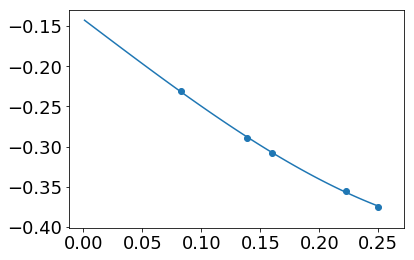

In [530]:
xs = np.linspace(0.001,0.25,100)


plt.figure()
plt.scatter(PSF_amp_ramp.ready_to_fit['x']['eta'], PSF_amp_ramp.ready_to_fit['y']['a0'])
plt.plot(xs, PSF_amp_ramp.model_evaluate('a0', xs))

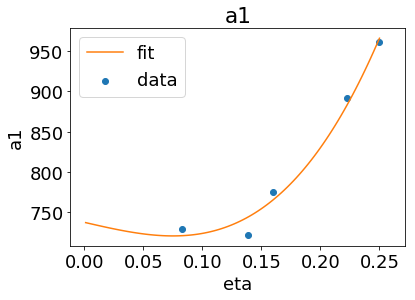

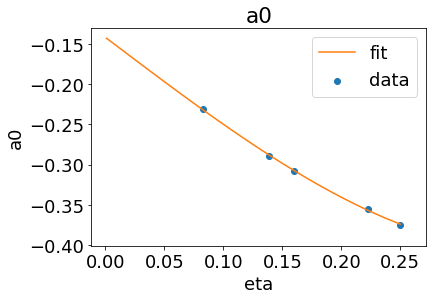

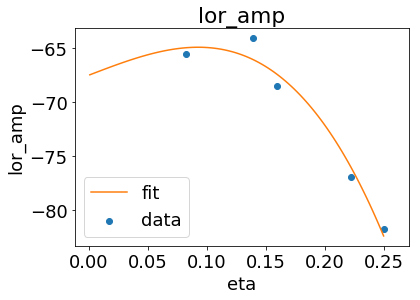

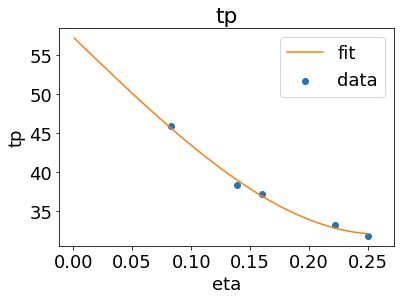

In [531]:
part = PSF_amp_ramp

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

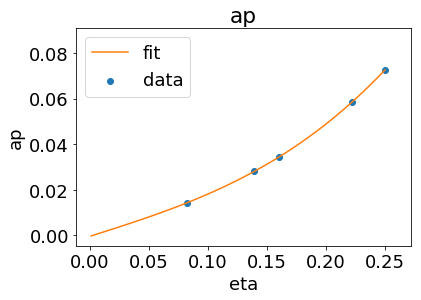

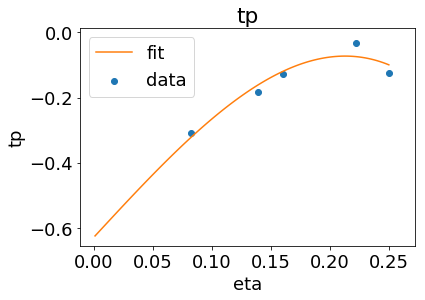

In [532]:
part = PSF_amp_bob

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

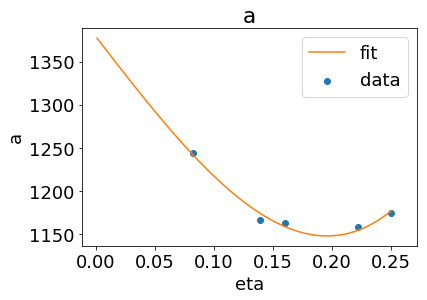

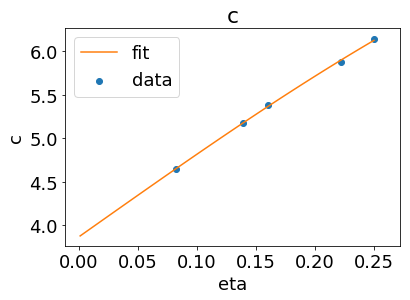

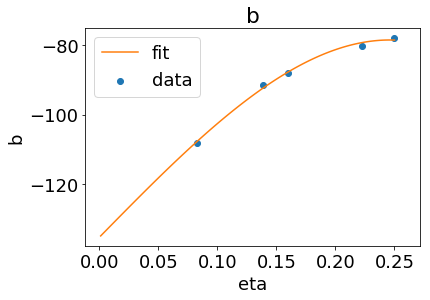

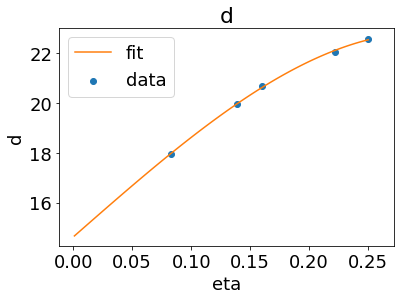

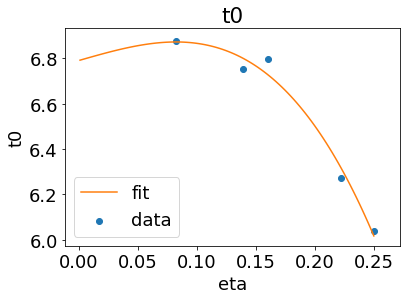

In [533]:
part = PSF_freq_ramp

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

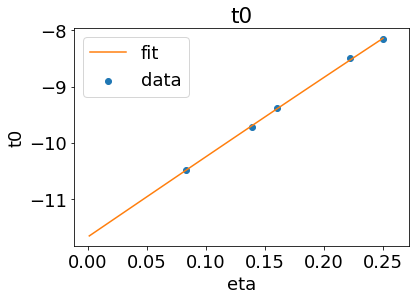

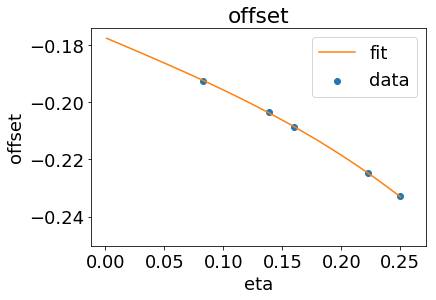

In [534]:
part = PSF_freq_mr

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

# Mark 1 model class

In [535]:
PSF_amp_ramp.results['q1']['fixed']

{'tdamp': 11.706422641558191}

In [536]:
PSF_amp_ramp.fixed_parnames

['tdamp']

In [537]:
PSF_amp_bob.fixed_parnames

['tdamp']

In [538]:
PSF_freq_mr.fixed_parnames

['b', 'kappa', 'om_f']

In [539]:
PSF_freq_ramp.fixed_parnames

[]

In [540]:
a=PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model

In [541]:
a?

In [542]:
PSF_freq_ramp.full_model_dict['q1'].freq_model

In [543]:
PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model

<bound method Model_frequency.freq_model of <__main__.Model_frequency object at 0x1209fb350>>

In [544]:
PSF_freq_mr.fixed_parnames

['b', 'kappa', 'om_f']

In [545]:
class ModelMark1(object):
    def __init__(self, times, q):
        """
        times to evaluate the model at
        q : mass-ratio
        """
        
        self.times = times
        self.q = q
        self.eta = eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        
        # amplitude model
        # build dict for params. parameter space fit values and fixed values
        # ramp_up
        params_ramp_up={}
        for k in PSF_amp_ramp.vary_parnames:
            params_ramp_up.update({k : PSF_amp_ramp.model_evaluate(k, self.eta)})
        params_ramp_up.update({'tdamp' : 1./self.fdamp/2./np.pi})
        
        # bob
        params_bob={}
        for k in PSF_amp_bob.vary_parnames:
            params_bob.update({k : PSF_amp_bob.model_evaluate(k, self.eta)})
        params_bob.update({'tdamp' : 1./self.fdamp/2./np.pi})
        
        amp_model_func = PSF_amp_ramp.full_model_dict['q1'].fit_fix_tdamp.amp_model
        self.amp_model = amp_model_func(self.times, t0=-10, sigma=10, params_ramp_up=params_ramp_up, params_bob=params_bob)

        
        # frequency model
        # build dict for params. parameter space fit values and fixed values
        # ramp_up
        params_freq_ramp_up={}
        for k in PSF_freq_ramp.vary_parnames:
            params_freq_ramp_up.update({k : PSF_freq_ramp.model_evaluate(k, self.eta)})
        
        # mr
        params_mr={}
        for k in PSF_freq_mr.vary_parnames:
            params_mr.update({k : PSF_freq_mr.model_evaluate(k, self.eta)})
        params_mr.update({
            'om_f' : -self.fring*2.*np.pi,
            'kappa' : 1.,
            'b' : 1./self.fdamp/2./np.pi
        })
        
        freq_model_func = PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model
        self.freq_model = freq_model_func(self.times, t0=-20, sigma=10, params_ramp_up=params_freq_ramp_up, params_mr=params_mr)
        
        # compute phase
        self.model_phase = compute_integral(self.times, self.freq_model)
        
        # psi4
        self.psi4lm = self.amp_model * np.exp(1.j * (self.model_phase))

In [546]:
psi4s['q1'].times[0]

-609.2446223111556

In [547]:
psi4s['q1'].times[-1]

70.75537768884442

In [548]:
# Mark1 = ModelMark1(np.linspace(-600, 60, 2000), 1)
Mark1 = ModelMark1(psi4s['q1'].times, 1)

(-100, 50)

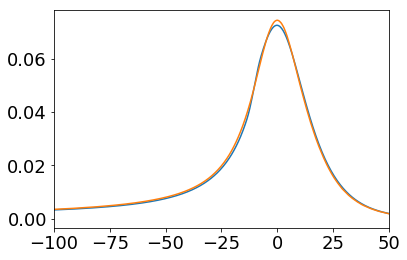

In [549]:
plt.figure()
plt.plot(Mark1.times, Mark1.amp_model)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_amp)
plt.xlim(-100,50)

(-100, 50)

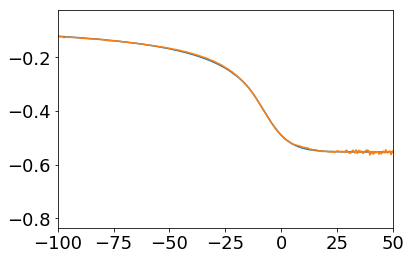

In [550]:
plt.figure()
plt.plot(Mark1.times, Mark1.freq_model)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_ang_freq)
plt.xlim(-100,50)

In [551]:
Mark1dict = {}
matches = {}
for k in psi4s.keys():
    q = psi4s[k].q
    Mark1dict.update({k: ModelMark1(psi4s[k].times, q)})
    m = match(Mark1dict[k].psi4lm, psi4s[k].psi4lm, Mark1dict[k].times)
    matches.update({k:m})
    print("{} = {}".format(q, np.max(np.abs(matches[k]))))

1.0 = 0.999512832208
2.0 = 0.999577435574
5.0 = 0.999428276911
10.0 = 0.998642015873
4.0 = 0.999383255902


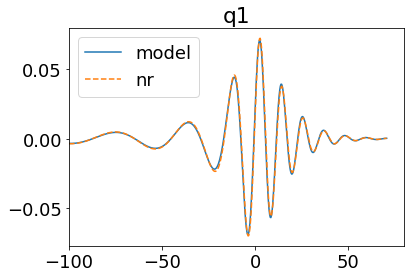

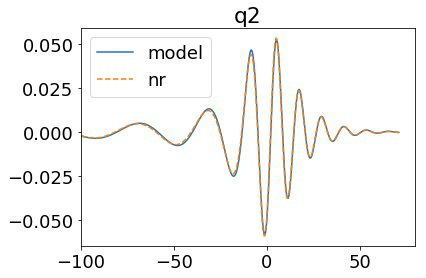

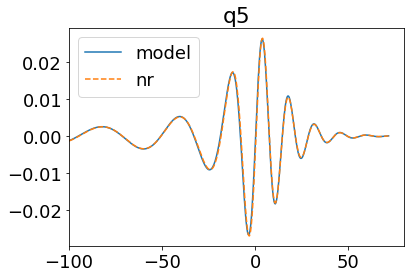

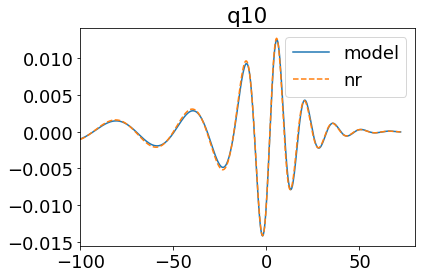

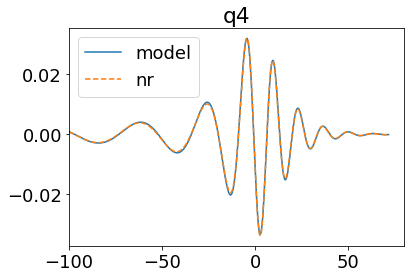

In [552]:
align_phases = True

for k in psi4s.keys():
    
    if align_phases:
        m_phase = np.unwrap(np.angle(Mark1dict[k].psi4lm))
        nr_phase = np.unwrap(np.angle(psi4s[k].psi4lm))
        avg_diff = np.mean(m_phase - nr_phase)
    
    
    plt.figure()
    plt.plot(Mark1dict[k].times, np.real(Mark1dict[k].psi4lm * np.exp(-1.j*avg_diff)), label='model')
    plt.plot(psi4s[k].times, np.real(psi4s[k].psi4lm), label='nr', ls='--')
#     plt.xlim(-400,80)
    plt.xlim(-100,80)
#     plt.xlim(-500,80)
#     plt.yscale('log')
    plt.legend()
    plt.title(k)
    plt.show()
    plt.close()

## extrapolating 

In [553]:
Mark1_ex = ModelMark1(np.linspace(-2000, 60, 2000), 100)

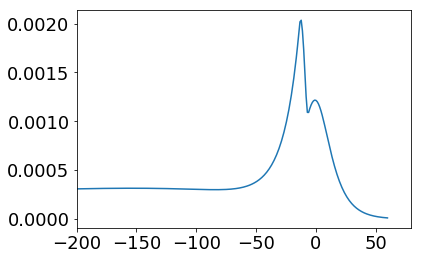

In [554]:
plt.figure()
# plt.plot(Mark1_ex.times, np.real(Mark1_ex.psi4lm), label='real')
# plt.plot(Mark1_ex.times, np.imag(Mark1_ex.psi4lm), label='imag')
plt.plot(Mark1_ex.times, np.abs(Mark1_ex.psi4lm), label='abs')
# plt.xlim(-500,80)
plt.xlim(-200,80)
# plt.xlim(-1000,80)
# plt.legend()
# plt.yscale('log')
plt.show()
plt.close()

## integrate psi4 to get strain and compare

In [555]:
int1re = compute_integral(psi4s['q1'].times, np.real(model_psi4))
int2re = compute_integral(psi4s['q1'].times, int1re)

int1imag = compute_integral(psi4s['q1'].times, np.imag(model_psi4))
int2imag = compute_integral(psi4s['q1'].times, int1imag)

/Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if sys.path[0] == '':
/Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if sys.path[0] == '':


In [556]:
int2re

array([9.17853860e-08, 3.08809813e-05, 1.23957048e-04, ...,
       3.14997019e+00, 3.15170940e+00, 3.15348570e+00])

In [557]:
int2imag

array([ 4.54119277e-08,  1.53121343e-05,  6.03827804e-05, ...,
       -6.61664512e+00, -6.62302201e+00, -6.62937988e+00])

(-300, 60)

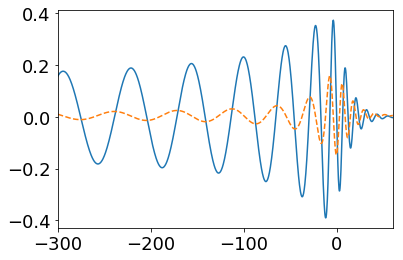

In [558]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].nrdata.hlm.real)
plt.plot(psi4s['q1'].times, np.real(int1re + 1.j*int1imag), ls='--')
plt.xlim(-300,60)

(-300, 60)

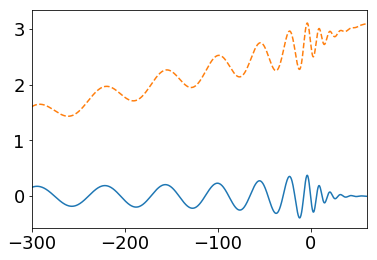

In [559]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].nrdata.hlm.real)
plt.plot(psi4s['q1'].times, np.real(int2re + 1.j*int2imag), ls='--')
plt.xlim(-300,60)

In [560]:
len(psi4s['q1'].times)/2 + 1

1001

In [561]:
# compute mode strain via fourier transform
fft_model_psi4 = np.fft.fft(model_psi4)
fft_model_psi4_freqs = np.fft.fftfreq( len(fft_model_psi4),  psi4s['q1'].times[1] - psi4s['q1'].times[0])

fft_model_strain = fft_model_psi4[1900:1995] / 4 / np.pi**2 / fft_model_psi4_freqs[1900:1995]**2



In [562]:
len(fft_model_psi4_freqs)

2000

In [563]:
fft_model_psi4_freqs

array([ 0.        ,  0.00146985,  0.00293971, ..., -0.00440956,
       -0.00293971, -0.00146985])

In [564]:
max(fft_model_psi4_freqs)

1.4683830882355018

In [565]:
ifft_model_strain = np.fft.ifft(fft_model_strain)

In [566]:
len( psi4s['q1'].times)

2000

In [567]:
len(ifft_model_strain)

95

In [568]:
len(fft_model_strain)

95

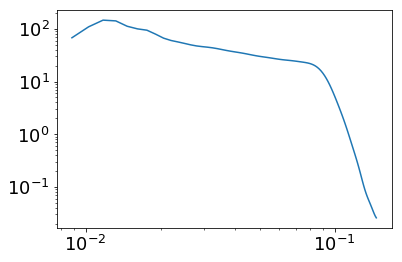

In [569]:
plt.figure()
plt.plot(np.abs(fft_model_psi4_freqs[1900:1995]), np.abs(fft_model_strain))
plt.yscale('log')
plt.xscale('log')

In [570]:
len(psi4s['q1'].times[2:998])

996

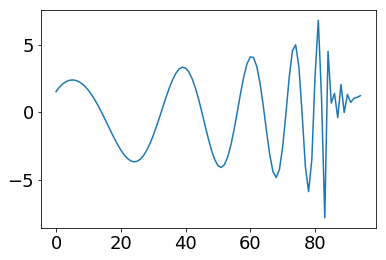

In [571]:
plt.figure()
# plt.plot(psi4s['q1'].times[2:998], np.abs(ifft_model_strain))
plt.plot(np.real(ifft_model_strain))
# plt.yscale('log')